In [1]:
import pandas as pd
import numpy as np
import os

# Load file CSV
df = pd.read_csv("dataset/datasetTubes.csv")

# Ambil header tahun dan kategori dari baris ke-1 dan ke-2
header_row_1 = df.iloc[1].ffill()
header_row_2 = df.iloc[2]

# Gabungkan menjadi nama kolom
multi_index = [
    f"{str(year).strip()} - {str(cat).strip()}"
    for year, cat in zip(header_row_1[1:], header_row_2[1:])
]

# Ambil data dari baris ke-4 ke bawah
data_rows = df.iloc[3:, :len(multi_index)+1]
data_rows.columns = ["Provinsi"] + multi_index
data_rows = data_rows[data_rows["Provinsi"].notna()]  # Hapus baris kosong

# Reshape ke long format
df_melted = data_rows.melt(id_vars="Provinsi", var_name="Tahun_Kategori", value_name="Nilai")

# Pisahkan menjadi dua kolom: Tahun dan Kategori
df_melted[['Tahun', 'Kategori']] = df_melted['Tahun_Kategori'].str.split(' - ', expand=True)

# Bersihkan nilai yang mengandung deskripsi panjang
# Hanya simpan baris yang Nilainya tampak seperti angka atau angka dengan koma
df_melted = df_melted[df_melted['Nilai'].str.contains(r'^\d+[\d,\.]*$', na=False)]

# Hapus koma, ubah ke float
df_melted['Nilai'] = df_melted['Nilai'].str.replace(',', '', regex=False).astype(float)

# Hapus kolom gabungan
df_melted.drop(columns="Tahun_Kategori", inplace=True)

# Simpan hasilnya ke file baru (opsional)
# Tentukan nama dasar file dan folder tujuan
base_filename = "datasetTubes_cleaned_fixed"
folder = "hasil-preposesing-data"
i = 1

# Cari nomor urutan file berikutnya yang belum ada
while True:
    output_filename = f"{base_filename}_{i}.csv"
    output_path = os.path.join(folder, output_filename)
    if not os.path.exists(output_path):
        break
    i += 1

# Simpan file dengan nama yang otomatis berurutan
df_melted.to_csv(output_path, index=False)

# Tampilkan pesan konfirmasi
print(f"File berhasil disimpan: {output_path}")
# df_melted.to_csv("hasil-preposesing-data/datasetTubes_cleaned_fixed.csv", index=False)

# Tampilkan hasil awal
print(df_melted.head())


File berhasil disimpan: hasil-preposesing-data\datasetTubes_cleaned_fixed_1.csv
           Provinsi     Nilai      Tahun       Kategori
0              Aceh    3363.9  2013-2014  Kawasan Hutan
1    Sumatera Utara    4675.2  2013-2014  Kawasan Hutan
2    Sumatera Barat    3330.3  2013-2014  Kawasan Hutan
3              Riau  180786.5  2013-2014  Kawasan Hutan
5  Sumatera Selatan    2853.5  2013-2014  Kawasan Hutan


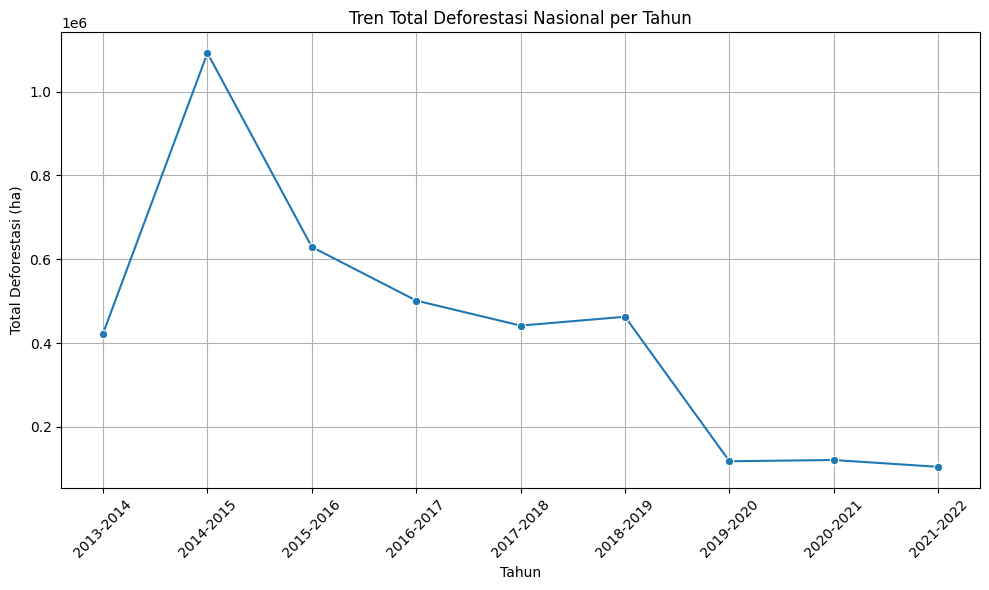

In [2]:
# 1. Tren Total Deforestasi Nasional per Tahun (Line Chart)
import matplotlib.pyplot as plt
import seaborn as sns

# Filter kategori deforestasi
df_deforestasi = df_melted[df_melted['Kategori'].str.contains("Deforestasi", case=False)]
# df_deforestasi = df_melted[df_melted['Kategori'].str.contains("Deforestasi", case=False)]

# Agregasi total per tahun
total_per_tahun = df_deforestasi.groupby("Tahun")["Nilai"].sum().reset_index()

# Visualisasi line chart
plt.figure(figsize=(10, 6))
sns.lineplot(data=total_per_tahun, x="Tahun", y="Nilai", marker="o")
plt.title("Tren Total Deforestasi Nasional per Tahun")
plt.ylabel("Total Deforestasi (ha)")
plt.xlabel("Tahun")
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()

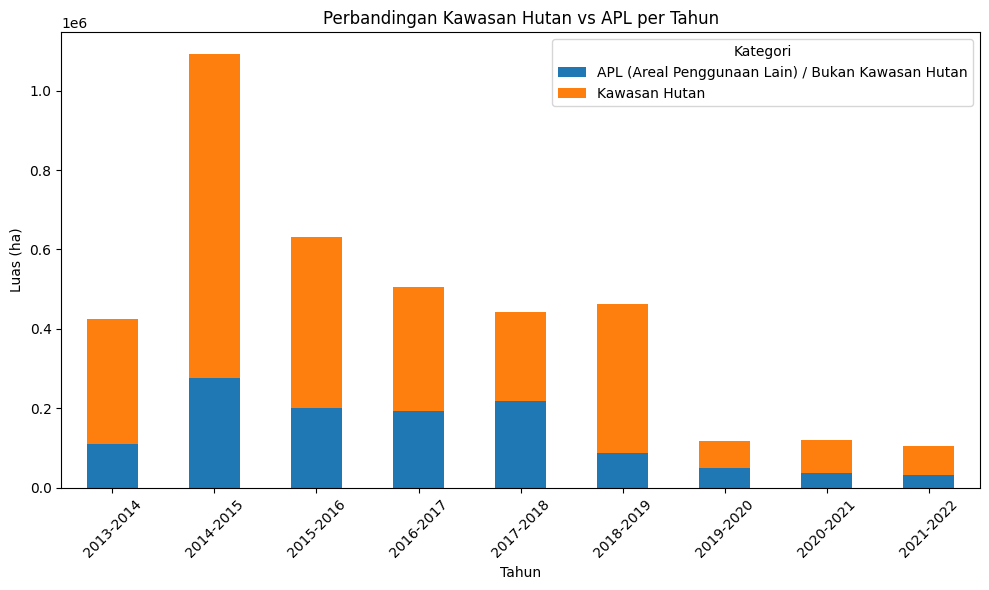

In [3]:
#  Perbandingan Kawasan Hutan vs APL per Tahun (Stacked Bar Chart)
# Filter data yang mengandung 'Kawasan Hutan' atau 'APL'
df_kawasan_apl = df_melted[df_melted['Kategori'].str.contains("Kawasan Hutan|APL", case=False)]

# Agregasi
kawasan_apl_tahun = df_kawasan_apl.groupby(['Tahun', 'Kategori'])['Nilai'].sum().unstack()

# Plot stacked bar chart
kawasan_apl_tahun.plot(kind='bar', stacked=True, figsize=(10, 6))
plt.title("Perbandingan Kawasan Hutan vs APL per Tahun")
plt.ylabel("Luas (ha)")
plt.xlabel("Tahun")
plt.xticks(rotation=45)
plt.legend(title="Kategori")
plt.tight_layout()
plt.show()


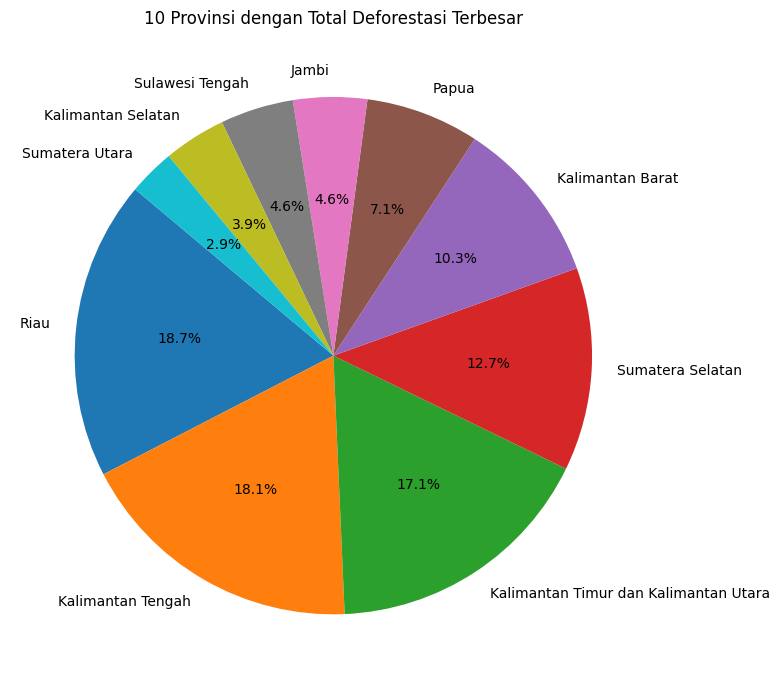

In [4]:
#  Perbandingan Kawasan Hutan vs APL per Tahun (Stacked Bar Chart)
# Agregasi total deforestasi per provinsi
top_deforestasi = df_deforestasi.groupby("Provinsi")["Nilai"].sum().sort_values(ascending=False)

# Ambil 10 provinsi teratas
top_10 = top_deforestasi.head(10)

# Pie chart
plt.figure(figsize=(8, 8))
top_10.plot(kind="pie", autopct="%1.1f%%", startangle=140)
plt.ylabel("")
plt.title("10 Provinsi dengan Total Deforestasi Terbesar")
plt.tight_layout()
plt.show()


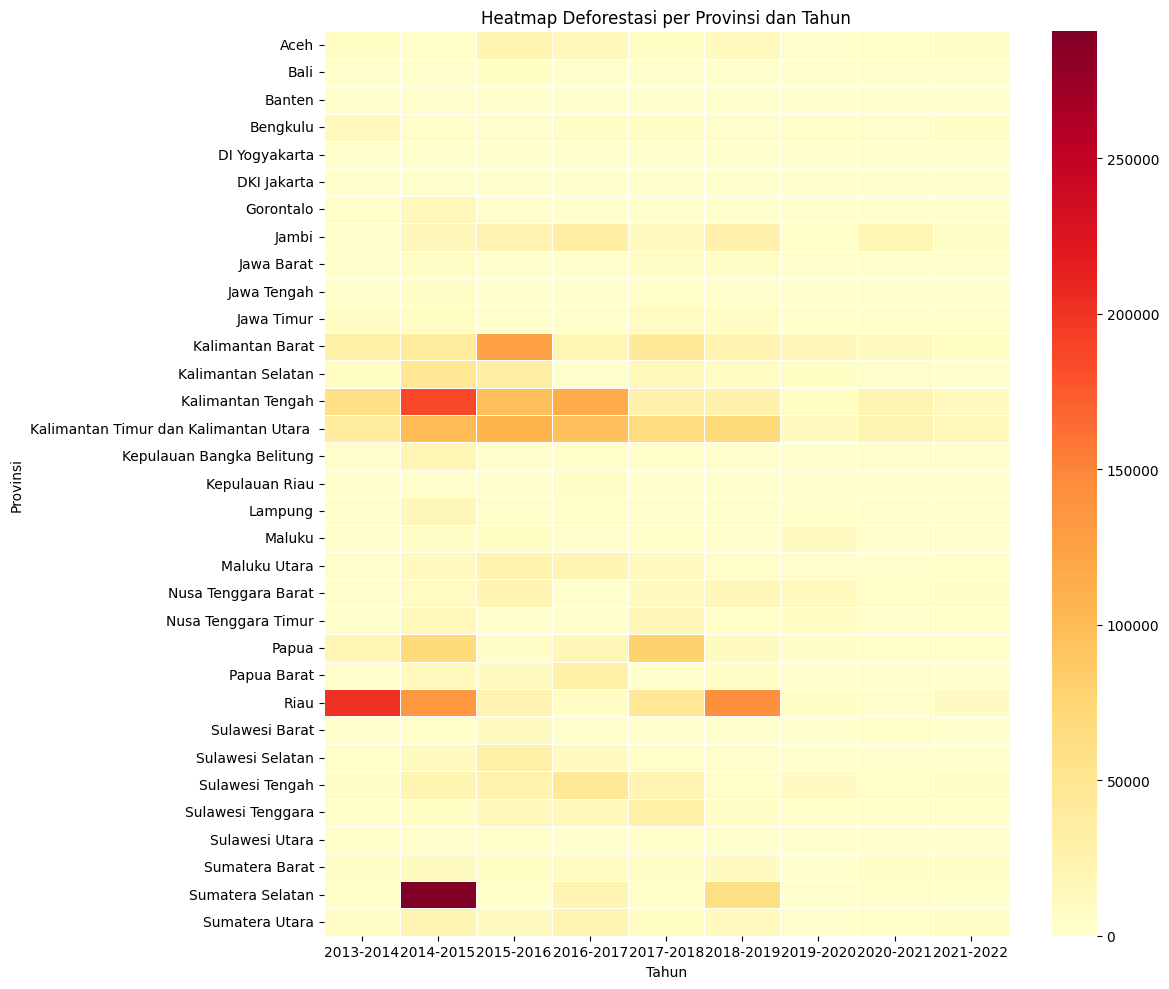

In [5]:
# 4. Heatmap Deforestasi per Provinsi dan Tahun
# Agregasi
heatmap_data = df_deforestasi.groupby(["Provinsi", "Tahun"])["Nilai"].sum().reset_index()
heatmap_pivot = heatmap_data.pivot(index="Provinsi", columns="Tahun", values="Nilai").fillna(0)

# Plot heatmap
plt.figure(figsize=(12, 10))
sns.heatmap(heatmap_pivot, cmap="YlOrRd", linewidths=0.5)
plt.title("Heatmap Deforestasi per Provinsi dan Tahun")
plt.xlabel("Tahun")
plt.ylabel("Provinsi")
plt.tight_layout()
plt.show()


In [ ]:
# 5 Map Deforestasi per Provinsi dan Tahun

import folium
import pandas as pd
import json

# Load data provinsi dan nilainya (pastikan nama provinsinya sesuai GeoJSON)
data = pd.read_csv("hasil-preposesing-data/datasetTubes_cleaned_fixed.csv")
data = data[data["Tahun"] == "2013"]  # Filter sesuai tahun
data = data[data["Kategori"] == "Kawasan Hutan"]

# Load GeoJSON provinsi Indonesia
with open("indonesia_provinces.geojson", "r", encoding="utf-8") as f:
    geojson = json.load(f)

# Buat peta dasar
m = folium.Map(location=[-2.5, 118], zoom_start=5)

# Tambahkan Choropleth
folium.Choropleth(
    geo_data=geojson,
    name="choropleth",
    data=data,
    columns=["Provinsi", "Nilai"],
    key_on="feature.properties.NAMPROV",  # Sesuaikan dengan key di GeoJSON
    fill_color="YlGn",
    fill_opacity=0.7,
    line_opacity=0.2,
    legend_name="Luas Deforestasi (ha)"
).add_to(m)

m.save("deforestasi_2013.html")


FileNotFoundError: [Errno 2] No such file or directory: 'indonesia_provinces.geojson'